Exploring torch for the sfNorm model

In [1]:
import torch
import torch.nn as nn
from torch.utils import data as torchdata

import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import seaborn as sns

import sys
sys.path.insert(0, '../')
import model_responses_pytorch as mrpt

import pdb


In [242]:
import autoreload as ar
ar.reload(mrpt);

In [243]:
### Helper
def _cast_as_tensor(x, device_in="cpu"):
    # needs to be float32 to work with the Hessian calculations
    return torch.tensor(x, dtype=torch.float32, device=device_in)

def _cast_as_param(x, device_in="cpu", requires_grad=True):
    # from Billy
    return torch.nn.Parameter(_cast_as_tensor(x, device_in=device_in), requires_grad=requires_grad)


In [244]:
### DATALOADER

class dataWrapper(torchdata.Dataset):   
    def __init__(self, sfs, resp, device='cpu'):
        super().__init__();

        self.sfs = sfs;
        self.resp = resp;
        self.device = device;
        
    def get_single_item(self, idx):
        feature = _cast_as_tensor(self.sfs[idx])
        target = _cast_as_tensor(self.resp[idx])
        return (feature.to(self.device), target.to(self.device));

    def __getitem__(self, idx):
        return self.get_single_item(idx)

    def __len__(self):
        return len(self.sfs)

In [245]:
### The model
class sfNormMod(torch.nn.Module):

    def __init__(self, modParams, excType=2, normType=1, lossType=1, lgnFrontEnd=0):
        super().__init__();
        
        self.excType = excType
        self.normType = normType;
        self.lossType = lossType;
        self.lgnFrontEnd = lgnFrontEnd;

        # testing flex gauss
        self.prefSf = _cast_as_param(modParams[0]);
        if excType == 2:
            self.sigLow = _cast_as_param(modParams[1]);
            highInd = -1-np.sign(lgnFrontEnd);
            self.sigHigh = _cast_as_param(modParams[highInd]);
        
        # testing DiffOfGauss
#         self.prefSf = _cast_as_param(modParams[0]);
#         self.gain = _cast_as_param(modParams[1]);
#         self.gainS = _cast_as_param(modParams[2]);
#         self.sfS = _cast_as_param(modParams[3]);

        # testing DoGsach
#         self.gain_c = _cast_as_param(modParams[0]);
#         self.gain_s = _cast_as_param(modParams[1]);
#         self.r_c = _cast_as_param(modParams[2]);
#         self.r_s = _cast_as_param(modParams[3]);

    def forward(self, stimSf):

#         s = mrpt.DoGsach(self.gain_c, self.r_c, self.gain_s, self.r_s, stimSf);
#         s = mrpt.DiffOfGauss(self.gain, self.prefSf, self.gainS, self.sfS, stimSf);
        s = mrpt.flexible_Gauss([_cast_as_tensor(0), _cast_as_tensor(1), self.prefSf, self.sigLow, self.sigHigh], stimSf, minThresh=0)

        return torch.clamp(s, min=1e-4);
    
def loss_sfNormMod(respModel, respData, lossType=1):

    if lossType == 1:
        lsq = torch.pow(torch.sign(respModel)*torch.sqrt(torch.abs(respModel)) - torch.sign(respData)*torch.sqrt(torch.abs(respData)), 2);
#         eps=1e-7
#         lsq = torch.log10(eps+ torch.pow(torch.sign(respModel)*torch.sqrt(torch.abs(respModel)) - torch.sign(respData)*torch.sqrt(torch.abs(respData)), 2));

        NLL = torch.mean(lsq);

    return NLL;

In [246]:
# testing flexible_Gauss
prefSf = 1;
sigLow = 0.9;
sigHigh = 0.4;
testMod = sfNormMod(modParams=[prefSf, sigLow, sigHigh])
trainMod = sfNormMod(modParams=[prefSf*3, sigLow, sigLow])

# testing DiffOfGauss
# prefSf, gain, gainS, sfS = 3, 1, 0.3, 0.3;
# testMod = sfNormMod(modParams=[prefSf, gain, gainS, sfS])
# trainMod = sfNormMod(modParams=[prefSf, gain, gainS, sfS])

# gain_c, gain_s, r_c, r_s = 100, 10, 0.5, 0.9;
# testMod = sfNormMod(modParams=[gain_c, gain_s, r_c, r_s])
# trainMod = sfNormMod(modParams=[gain_c, gain_s, 2*r_c, r_s])


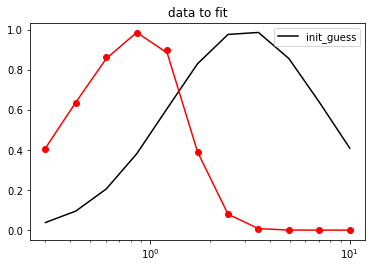

In [247]:
### Simple example -- can we recover the original parameters with some added noise...
sfs_data = np.geomspace(0.3, 10.0, 11);
gt_resp = testMod.forward(_cast_as_tensor(sfs_data)).detach().numpy();
# gt_detach = [x.detach().numpy() for x in gt_resp];
sfs_resp = np.clip(np.array([np.random.normal(x, scale=0.01*x) for x in gt_resp]), a_min=1e-4, a_max=None)

init_resp = trainMod.forward(_cast_as_tensor(sfs_data)).detach().numpy();

plt.semilogx(sfs_data, init_resp, 'k', label='init_guess');
plt.semilogx(sfs_data, gt_resp, 'r');
plt.semilogx(sfs_data, sfs_resp, 'ro')
plt.title('data to fit');
plt.legend();

In [248]:
training_parameters = [p for p in model.parameters() if p.requires_grad]
batch_size = 2;
dataset = _cast_as_tensor(sfs_resp);
max_epochs = 4;
full_data = np.zeros((len(sfs_data), 2));
full_data[:,0] = sfs_data;
full_data[:,1] = sfs_resp;

In [252]:
### Now, the optimization
# - what to specify...
model = trainMod; # what's our model?

learning_rate = 0.001;
training_parameters = [p for p in model.parameters() if p.requires_grad]
batch_size = 3;
dataset = _cast_as_tensor(sfs_resp);
max_epochs = 1000;
full_data = np.zeros((len(sfs_data), 2));
full_data[:,0] = sfs_data;
full_data[:,1] = sfs_resp;

# - then set it up
# optimizer = torch.optim.SGD(training_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(training_parameters, amsgrad=True, lr=learning_rate, )
# - then data
full_data = dataWrapper(sfs_data, sfs_resp)
dataloader = torchdata.DataLoader(full_data, batch_size)
# - predefine some arrays for tracking loss
loss_history = []
start_time = time.time()
time_history = []
model_history = []
hessian_history = []

first_pred = model(_cast_as_tensor(sfs_data));
# print(first_pred)

for t in range(max_epochs):
    optimizer.zero_grad()

    loss_history.append([])
    time_history.append([])

    for i, (features, target) in enumerate(dataloader):
    
#         features, target = _cast_as_tensor(sfs_data), _cast_as_tensor(sfs_resp);
#         features, target = _cast_as_tensor(sfs_data), _cast_as_tensor(sfs_resp);

        predictions = model(features)
        loss_curr = loss_sfNormMod(predictions, target, model.lossType)
        loss_history[t].append(loss_curr.item())
        time_history[t].append(time.time() - start_time)
        if np.isnan(loss_curr.item()) or np.isinf(loss_curr.item()):
            # we raise an exception here and then try again.
            raise Exception("Loss is nan or inf on epoch %s, batch %s!" % (t, i))
        loss_curr.backward()
        optimizer.step()

    model.eval()
    model.train()


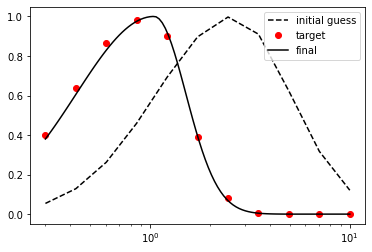

In [253]:
plt.semilogx(sfs_data, first_pred.detach().numpy(), 'k--', label='initial guess')
plt.semilogx(sfs_data, sfs_resp, 'ro', label='target');
sfs_full = np.geomspace(sfs_data[0], sfs_data[-1], 100);
plt.semilogx(sfs_full, model(_cast_as_tensor(sfs_full)).detach().numpy(), 'k', label='final');
plt.legend()

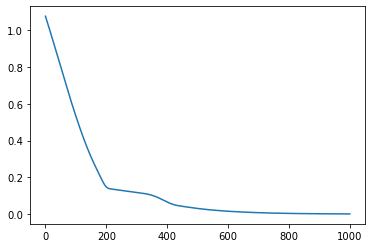

In [254]:
plt.plot(np.sum(loss_history, axis=1))

In [211]:
out_parameters = [p for p in model.parameters() if p.requires_grad]


In [212]:
out_parameters

[Parameter containing:
 tensor(99.3644, requires_grad=True),
 Parameter containing:
 tensor(10.6046, requires_grad=True),
 Parameter containing:
 tensor(0.4962, requires_grad=True),
 Parameter containing:
 tensor(1.2485, requires_grad=True)]

In [213]:
og_pms = [prefSf, gain, gainS, sfS]

In [214]:
og_pms

[3, 1, 0.3, 0.3]